### Scoring sequence segments
It is possible to score with AntPack while masking out or disregarding user-specified regions of
the sequence. This notebook generates scores for specific CDRs and framework regions to determine
how easily they can be distinguished across species.

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.metrics import roc_auc_score
from antpack import SequenceScoringTool, SingleChainAnnotator

if "notebooks" in os.getcwd():
    os.chdir(os.path.join("..", ".."))
    current_dir = os.getcwd()

score_tool = SequenceScoringTool()

os.chdir(current_dir)

tt_dir = [f for f in os.listdir() if f.startswith("train_test_data_immunogenicity")]
if len(tt_dir) != 1:
    raise ValueError("Data not downloaded yet, or multiple versions of data downloaded.")

tt_dir = tt_dir[0]

In [2]:
from antpack.constants.scoring_constants import allowed_imgt_pos as ahip

The next function scores a batch of sequences using various masks.

In [3]:
def score_sequence_group(seqs, chain, region, scoring_tool):
    light_mask = scoring_tool.get_standard_mask("L", region)
    heavy_mask = scoring_tool.get_standard_mask("H", region)
    scores = scoring_tool.score_seqs(seqs, custom_light_mask = light_mask,
                                    custom_heavy_mask = heavy_mask).tolist()
    mask_categories = [region for a in seqs]
    return scores, mask_categories

We now run the above function on each batch of 50,000 sequences in the test set. There are 450,000 sequences in
all and we are scoring them using many different settings, so this will take a few minutes.

In [4]:
if "results_and_resources" not in os.getcwd():
    os.chdir(os.path.join(current_dir, "results_and_resources"))


scoring = { chain:{"scores":[], "species":[], "labels":[], "mask_codes":[]} for chain in ["heavy", "light"]  }


for chain in ["heavy", "light"]:
    os.chdir(os.path.join(current_dir, tt_dir, f"{chain}_chain", "test_sample_sequences"))
    flist = [f for f in os.listdir() if f.endswith("fasta")]
    flist = sorted(flist)

    for region in ["framework_1", "cdr_1", "framework_2", "cdr_2", "framework_3", "cdr_3",
                   "framework_4"]:
        print(region)
        
        for fname in flist:
            print(fname)
            with open(fname, "r") as fhandle:
                slist = [str(s.seq) for s in SeqIO.parse(fhandle, "fasta")]

            scores, mask_cats = score_sequence_group(slist, chain, region, score_tool)
        
            species = fname.split(".fasta")[0].split("test_subsample_")[1]
            if species.startswith("mouse"):
                scoring[chain]["species"] += ["mouse" for s in scores]
            else:
                scoring[chain]["species"] += [species for s in scores]
            scoring[chain]["scores"] += scores
            scoring[chain]["mask_codes"] += mask_cats

            if species == "human":
                scoring[chain]["labels"] += np.ones((len(scores))).tolist()
            else:
                scoring[chain]["labels"] += np.zeros((len(scores))).tolist()

framework_1
test_subsample_camel.fasta
test_subsample_human.fasta
test_subsample_mouse_balbc.fasta
test_subsample_mouse_c576.fasta
test_subsample_rabbit.fasta
test_subsample_rat.fasta
test_subsample_rhesus.fasta
cdr_1
test_subsample_camel.fasta
test_subsample_human.fasta
test_subsample_mouse_balbc.fasta
test_subsample_mouse_c576.fasta
test_subsample_rabbit.fasta
test_subsample_rat.fasta
test_subsample_rhesus.fasta
framework_2
test_subsample_camel.fasta
test_subsample_human.fasta
test_subsample_mouse_balbc.fasta
test_subsample_mouse_c576.fasta
test_subsample_rabbit.fasta
test_subsample_rat.fasta
test_subsample_rhesus.fasta
cdr_2
test_subsample_camel.fasta
test_subsample_human.fasta
test_subsample_mouse_balbc.fasta
test_subsample_mouse_c576.fasta
test_subsample_rabbit.fasta
test_subsample_rat.fasta
test_subsample_rhesus.fasta
framework_3
test_subsample_camel.fasta
test_subsample_human.fasta
test_subsample_mouse_balbc.fasta
test_subsample_mouse_c576.fasta
test_subsample_rabbit.fasta
test_

In [5]:
dfs = {h:pd.DataFrame.from_dict(d) for (h,d) in scoring.items()}

In [6]:
dfs["heavy"].columns

Index(['scores', 'species', 'labels', 'mask_codes'], dtype='object')

In [7]:
from sklearn.metrics import average_precision_score

for chain in ["heavy", "light"]:
    print(f"AUC-ROC results, chain {chain}")
    df = dfs[chain]

    for mask in df.mask_codes.unique():
        subset = df[df["mask_codes"] == mask]
        auc_values, prc_values = [], []
        gt_scores = subset["labels"].values
        input_scores = subset["scores"].values
        rng = np.random.default_rng(123)

        for i in range(1000):
            idx = rng.choice(gt_scores.shape[0], gt_scores.shape[0])
            auc_values.append(roc_auc_score(gt_scores[idx], input_scores[idx]))
            prc_values.append(average_precision_score(gt_scores[idx], input_scores[idx]))

        auc_values = np.sort(np.array(auc_values))
        prc_values = np.sort(np.array(prc_values))
        score = roc_auc_score(gt_scores, input_scores)
        prc = average_precision_score(gt_scores, input_scores)

        print(f"{mask}, AUC-ROC:\t{score}\tLCB: {auc_values[25]}\tUCB:{auc_values[975]}")
        print(f"{mask}, AUC-PRC:\t{prc}\tLCB: {prc_values[25]}\tUCB:{prc_values[975]}\n")

    print("\n")

AUC-ROC results, chain heavy
framework_1, AUC-ROC:	0.8891843963192638	LCB: 0.8876924009705014	UCB:0.8906656427451147
framework_1, AUC-PRC:	0.6690288502634957	LCB: 0.6646601675976582	UCB:0.6733957988765705

cdr_1, AUC-ROC:	0.7722824187637527	LCB: 0.7701081456793233	UCB:0.7743888354399572
cdr_1, AUC-PRC:	0.4140062128925137	LCB: 0.40971173352333007	UCB:0.4180745647763635

framework_2, AUC-ROC:	0.9039500713742749	LCB: 0.9026402369990086	UCB:0.9053012850900859
framework_2, AUC-PRC:	0.6370142752171665	LCB: 0.6328001068236722	UCB:0.6414449142531573

cdr_2, AUC-ROC:	0.8326907744348868	LCB: 0.8305979063184591	UCB:0.8349489739911524
cdr_2, AUC-PRC:	0.6448250299190803	LCB: 0.6410439676133364	UCB:0.6490762208381822

framework_3, AUC-ROC:	0.8657859848369673	LCB: 0.8640638589734394	UCB:0.8674299518368064
framework_3, AUC-PRC:	0.6550680450870827	LCB: 0.6514583200124743	UCB:0.6588777666807166

cdr_3, AUC-ROC:	0.5098494576115223	LCB: 0.5072262446928617	UCB:0.5125851408540085
cdr_3, AUC-PRC:	0.227596719

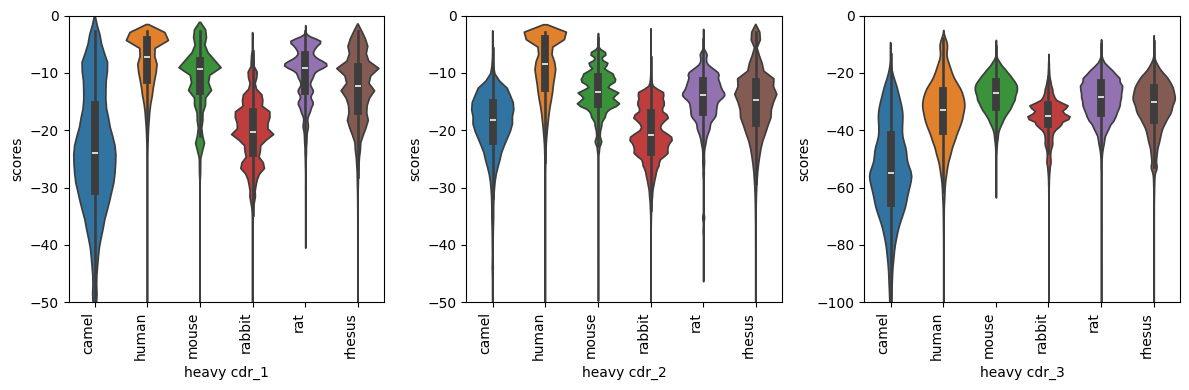

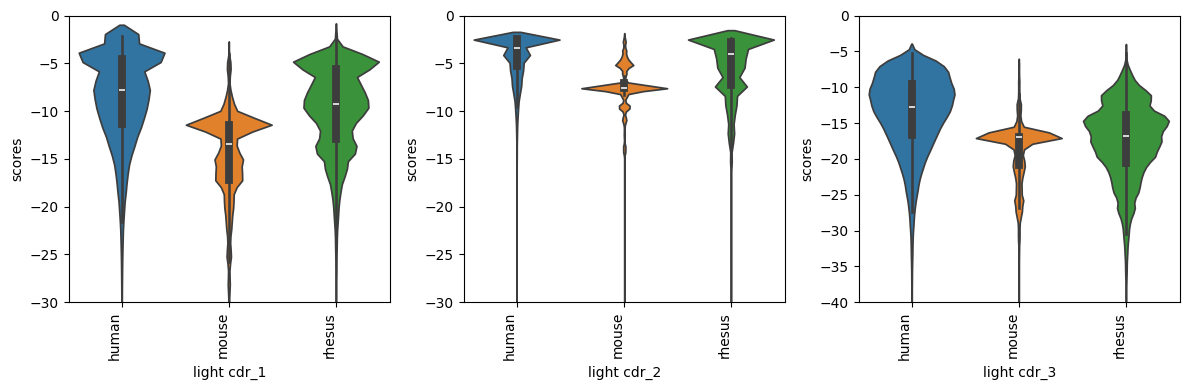

In [8]:
os.chdir(current_dir)

for chain in ["heavy", "light"]:
    fig, ((ax1,ax2,ax3)) = plt.subplots(1,3, figsize=(12,4), sharex=True)
    axes = [ax1, ax2, ax3]
    df = dfs[chain]

    mask_lists = [mask for mask in df.mask_codes.unique().tolist() if mask.startswith("cdr")]
    
    for mask, ax in zip(mask_lists, axes):
        subset = df[df["mask_codes"] == mask]
        sns.violinplot(y=subset["scores"], x=subset["species"],
                    hue=subset["species"], ax=ax)
    
    
        for label in ax.get_xticklabels():
            label.set_rotation(90)
            label.set_ha('right')
        if chain == "heavy":
            if mask in ("cdr_2", "cdr_1"):
                ax.set_ylim(-50,0)
            else:
                ax.set_ylim(-100,0)
        else:
            if mask in ("cdr_2", "cdr_1"):
                ax.set_ylim(-30,0)
            else:
                ax.set_ylim(-40,0)
        ax.set_xlabel(f"{chain} {mask}")

    plt.tight_layout()
    plt.savefig(f"{chain} CDR regions only.png")
    plt.show()

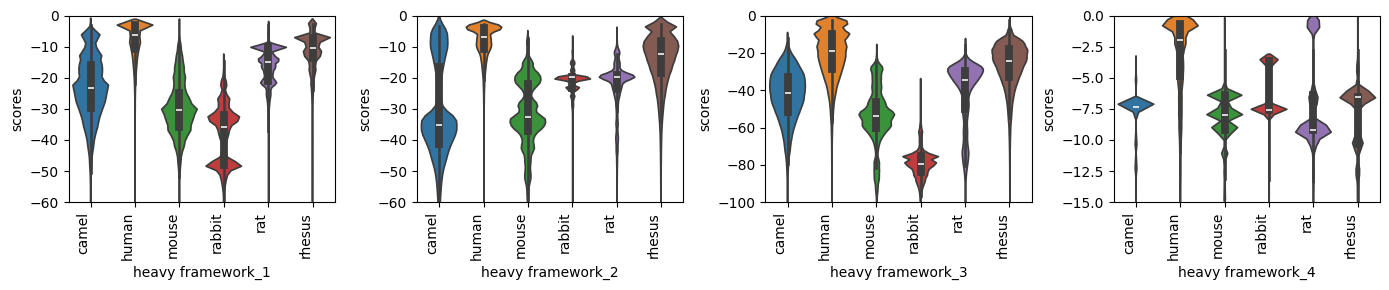

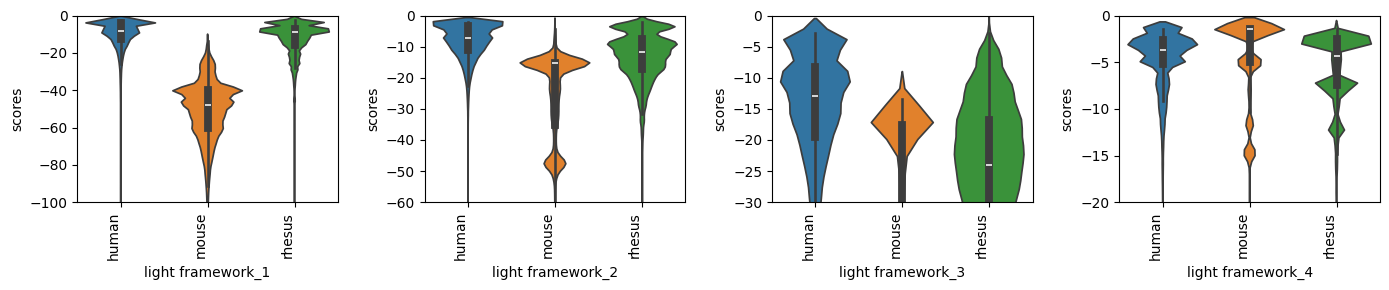

In [9]:
os.chdir(current_dir)

for chain in ["heavy", "light"]:
    fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1,4, figsize=(14,3), sharex=True)
    axes = [ax1, ax2, ax3, ax4]
    df = dfs[chain]

    mask_lists = [mask for mask in df.mask_codes.unique().tolist() if mask.startswith("framework")]
    
    for mask, ax in zip(mask_lists, axes):
        subset = df[df["mask_codes"] == mask]
        sns.violinplot(y=subset["scores"], x=subset["species"],
                    hue=subset["species"], ax=ax)
    
    
        for label in ax.get_xticklabels():
            label.set_rotation(90)
            label.set_ha('right')


        #TODO: clean this up
        if chain == "heavy":
            if mask in ("framework_1", "framework_2"):
                ax.set_ylim(-60,0)
            elif mask == "framework_3":
                ax.set_ylim(-100,0)
            else:
                ax.set_ylim(-15,0)
        else:
            if mask == "framework_1":
                ax.set_ylim(-100,0)
            elif mask == "framework_2":
                ax.set_ylim(-60,0)
            elif mask == "framework_3":
                ax.set_ylim(-30,0)
            else:
                ax.set_ylim(-20,0)
        ax.set_xlabel(f"{chain} {mask}")

    plt.tight_layout()
    plt.savefig(f"{chain} Framework regions only.png")
    plt.show()

In [10]:
for chain in ["heavy", "light"]:
    print(f"AUC-ROC results, chain {chain}, mouse-human only")
    df = dfs[chain]

    for mask in df.mask_codes.unique():
        subset = df[df["mask_codes"] == mask]
        subset = subset[subset["species"].isin(("human", "mouse"))]
        auc_values, prc_values = [], []
        gt_scores = subset["labels"].values
        input_scores = subset["scores"].values
        rng = np.random.default_rng(123)

        for i in range(1000):
            idx = rng.choice(gt_scores.shape[0], gt_scores.shape[0])
            auc_values.append(roc_auc_score(gt_scores[idx], input_scores[idx]))
            prc_values.append(average_precision_score(gt_scores[idx], input_scores[idx]))

        auc_values = np.sort(np.array(auc_values))
        prc_values = np.sort(np.array(prc_values))
        score = roc_auc_score(gt_scores, input_scores)
        prc = average_precision_score(gt_scores, input_scores)

        print(f"{mask}, AUC-ROC:\t{score}\tLCB: {auc_values[25]}\tUCB:{auc_values[975]}")
        print(f"{mask}, AUC-PRC:\t{prc}\tLCB: {prc_values[25]}\tUCB:{prc_values[975]}\n")

    print("\n")

AUC-ROC results, chain heavy, mouse-human only
framework_1, AUC-ROC:	0.9740023691212066	LCB: 0.9731907480187695	UCB:0.9748510378841392
framework_1, AUC-PRC:	0.9763321518141339	LCB: 0.9755629884282957	UCB:0.9771264934551354

cdr_1, AUC-ROC:	0.6564113620996619	LCB: 0.6530006076382686	UCB:0.6598432155219305
cdr_1, AUC-PRC:	0.641435554471234	LCB: 0.6370487148634207	UCB:0.6460594891631353

framework_2, AUC-ROC:	0.9777572009842166	LCB: 0.9770075858826217	UCB:0.978551770532273
framework_2, AUC-PRC:	0.9803810558231314	LCB: 0.9797213493529716	UCB:0.9811127613490958

cdr_2, AUC-ROC:	0.7479084430574727	LCB: 0.7449682990887302	UCB:0.7510244104927373
cdr_2, AUC-PRC:	0.8073174099808162	LCB: 0.8046151943382693	UCB:0.8101712701377908

framework_3, AUC-ROC:	0.947575062913841	LCB: 0.9461572621753799	UCB:0.9489811086308614
framework_3, AUC-PRC:	0.9562020206094085	LCB: 0.9550718235254362	UCB:0.9573913833110019

cdr_3, AUC-ROC:	0.32591772870031405	LCB: 0.32261691094326317	UCB:0.3293691428903282
cdr_3, AUC-

In [11]:
for chain in ["heavy"]:
    print(f"AUC-ROC results, chain {chain}, RAT-HUMAN ONLY")
    df = dfs[chain]

    for mask in df.mask_codes.unique():
        subset = df[df["mask_codes"] == mask]
        subset = subset[subset["species"].isin(("human", "rat"))]
        auc_values, prc_values = [], []
        gt_scores = subset["labels"].values
        input_scores = subset["scores"].values
        rng = np.random.default_rng(123)

        for i in range(1000):
            idx = rng.choice(gt_scores.shape[0], gt_scores.shape[0])
            auc_values.append(roc_auc_score(gt_scores[idx], input_scores[idx]))
            prc_values.append(average_precision_score(gt_scores[idx], input_scores[idx]))

        auc_values = np.sort(np.array(auc_values))
        prc_values = np.sort(np.array(prc_values))
        score = roc_auc_score(gt_scores, input_scores)
        prc = average_precision_score(gt_scores, input_scores)

        print(f"{mask}, AUC-ROC:\t{score}\tLCB: {auc_values[25]}\tUCB:{auc_values[975]}")
        print(f"{mask}, AUC-PRC:\t{prc}\tLCB: {prc_values[25]}\tUCB:{prc_values[975]}\n")

    print("\n")

AUC-ROC results, chain heavy, RAT-HUMAN ONLY
framework_1, AUC-ROC:	0.8628906971254826	LCB: 0.860501015009729	UCB:0.8653492352514786
framework_1, AUC-PRC:	0.900192433005749	LCB: 0.8981586450887579	UCB:0.9020825139766389

cdr_1, AUC-ROC:	0.6404891706507171	LCB: 0.637218680582673	UCB:0.6440432101880823
cdr_1, AUC-PRC:	0.711650936411325	LCB: 0.7081357261045703	UCB:0.7151426530519959

framework_2, AUC-ROC:	0.9503583026944851	LCB: 0.9489430283767655	UCB:0.9517575624440665
framework_2, AUC-PRC:	0.9633521457082308	LCB: 0.962338292518468	UCB:0.9643431784864038

cdr_2, AUC-ROC:	0.7852295169130443	LCB: 0.7824008708383152	UCB:0.787943312181367
cdr_2, AUC-PRC:	0.8395541347577788	LCB: 0.8370452423499302	UCB:0.8419815878696862

framework_3, AUC-ROC:	0.8530339253065553	LCB: 0.8506947351052025	UCB:0.8553562717214515
framework_3, AUC-PRC:	0.894252438608879	LCB: 0.8923438236737387	UCB:0.896169052307588

cdr_3, AUC-ROC:	0.3721050135024304	LCB: 0.3686771063857802	UCB:0.3756346162523572
cdr_3, AUC-PRC:	0.47

In [12]:
for chain in ["heavy"]:
    print(f"AUC-ROC results, chain {chain}, CAMEL-HUMAN ONLY")
    df = dfs[chain]

    for mask in df.mask_codes.unique():
        subset = df[df["mask_codes"] == mask]
        subset = subset[subset["species"].isin(("human", "camel"))]
        auc_values, prc_values = [], []
        gt_scores = subset["labels"].values
        input_scores = subset["scores"].values
        rng = np.random.default_rng(123)

        for i in range(1000):
            idx = rng.choice(gt_scores.shape[0], gt_scores.shape[0])
            auc_values.append(roc_auc_score(gt_scores[idx], input_scores[idx]))
            prc_values.append(average_precision_score(gt_scores[idx], input_scores[idx]))

        auc_values = np.sort(np.array(auc_values))
        prc_values = np.sort(np.array(prc_values))
        score = roc_auc_score(gt_scores, input_scores)
        prc = average_precision_score(gt_scores, input_scores)

        print(f"{mask}, AUC-ROC:\t{score}\tLCB: {auc_values[25]}\tUCB:{auc_values[975]}")
        print(f"{mask}, AUC-PRC:\t{prc}\tLCB: {prc_values[25]}\tUCB:{prc_values[975]}\n")

    print("\n")

AUC-ROC results, chain heavy, CAMEL-HUMAN ONLY
framework_1, AUC-ROC:	0.915082842541105	LCB: 0.9132904745551613	UCB:0.9168197738157475
framework_1, AUC-PRC:	0.918467484612639	LCB: 0.9166440997715983	UCB:0.9201802366957149

cdr_1, AUC-ROC:	0.8946147439692763	LCB: 0.8925789866840274	UCB:0.8965797652935757
cdr_1, AUC-PRC:	0.8550970536166926	LCB: 0.8512688353585071	UCB:0.8587835914890696

framework_2, AUC-ROC:	0.9023389200704084	LCB: 0.9003844278112983	UCB:0.9042616241588606
framework_2, AUC-PRC:	0.8822544643283204	LCB: 0.8795046816428845	UCB:0.8847628161157841

cdr_2, AUC-ROC:	0.9034456828819458	LCB: 0.9016248166625005	UCB:0.9052269380304698
cdr_2, AUC-PRC:	0.9263326901072415	LCB: 0.9247462078520217	UCB:0.9278053698447555

framework_3, AUC-ROC:	0.8824190430851703	LCB: 0.8801986007509724	UCB:0.8844979964472568
framework_3, AUC-PRC:	0.9052148608568021	LCB: 0.9033392258438231	UCB:0.9070663065715484

cdr_3, AUC-ROC:	0.8420908577029244	LCB: 0.8396587442200549	UCB:0.8446463493186319
cdr_3, AUC-P

In [14]:
for chain in ["heavy", "light"]:
    print(f"AUC-ROC results, chain {chain}, RHESUS-HUMAN ONLY")
    df = dfs[chain]

    for mask in df.mask_codes.unique():
        subset = df[df["mask_codes"] == mask]
        subset = subset[subset["species"].isin(("human", "rhesus"))]
        auc_values, prc_values = [], []
        gt_scores = subset["labels"].values
        input_scores = subset["scores"].values
        rng = np.random.default_rng(123)

        for i in range(1000):
            idx = rng.choice(gt_scores.shape[0], gt_scores.shape[0])
            auc_values.append(roc_auc_score(gt_scores[idx], input_scores[idx]))
            prc_values.append(average_precision_score(gt_scores[idx], input_scores[idx]))

        auc_values = np.sort(np.array(auc_values))
        prc_values = np.sort(np.array(prc_values))
        score = roc_auc_score(gt_scores, input_scores)
        prc = average_precision_score(gt_scores, input_scores)

        print(f"{mask}, AUC-ROC:\t{score}\tLCB: {auc_values[25]}\tUCB:{auc_values[975]}")
        print(f"{mask}, AUC-PRC:\t{prc}\tLCB: {prc_values[25]}\tUCB:{prc_values[975]}\n")

    print("\n")

AUC-ROC results, chain heavy, RHESUS-HUMAN ONLY
framework_1, AUC-ROC:	0.6989507514450867	LCB: 0.6955573006460514	UCB:0.7019477531814508
framework_1, AUC-PRC:	0.7304561313270157	LCB: 0.7263265590099	UCB:0.734367713242825

cdr_1, AUC-ROC:	0.7302805308318499	LCB: 0.7272732227936031	UCB:0.7332693461400366
cdr_1, AUC-PRC:	0.7399415941131333	LCB: 0.735951699231558	UCB:0.7439558958973977

framework_2, AUC-ROC:	0.7307254951297077	LCB: 0.7275934754932145	UCB:0.7338580763806223
framework_2, AUC-PRC:	0.7092844056364684	LCB: 0.7052506187120515	UCB:0.7137695099701257

cdr_2, AUC-ROC:	0.7915850247014821	LCB: 0.7889548678806586	UCB:0.7943650855048616
cdr_2, AUC-PRC:	0.806205407225917	LCB: 0.8029834340321167	UCB:0.8094583678965643

framework_3, AUC-ROC:	0.6484196205772347	LCB: 0.6451039562436248	UCB:0.6518925415158463
framework_3, AUC-PRC:	0.7155488177614109	LCB: 0.7118878464726119	UCB:0.7190801832356932

cdr_3, AUC-ROC:	0.43846531691901514	LCB: 0.43475437019707264	UCB:0.442214982235976
cdr_3, AUC-PRC